# Przygotowanie danych do projektu - wersja poprawiona


### Wczytanie pakietów oraz zbioru danych

In [1]:
# data prep
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
!pip install yfinance
import yfinance as yf
from sklearn.preprocessing import LabelEncoder

# technical analysis
! pip install ta
from ta.others import daily_return
from ta.others import cumulative_return
from ta.volatility import BollingerBands
from ta.volatility import DonchianChannel
from ta.trend import CCIIndicator
from ta.trend import EMAIndicator
from ta.momentum import KAMAIndicator
from ta.momentum import PercentageVolumeOscillator
from ta.momentum import PercentagePriceOscillator
from ta.momentum import ROCIndicator

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/UMF/CONVICTIONLISTTOPN_BSLD-408.csv", sep=",", header=None)
df

,0,1,2,3,4,5,6
0,10:01:54.481 77425 [77425-thread-2] INFO a.s....,2004-02-11,SU,SU,Energy Minerals,GN63J3-R,0.953727
1,10:01:54.481 77425 [77425-thread-2] INFO a.s....,2004-02-11,GGG,GGG,Producer Manufacturing,H5490W-R,0.952753
2,10:01:54.481 77425 [77425-thread-2] INFO a.s....,2004-02-11,WGR,WGR,Energy Minerals,V0622Q-R,0.947634
3,10:01:54.481 77425 [77425-thread-2] INFO a.s....,2004-02-11,CWT,CWT,Utilities,GSWXLY-R,0.934181
4,10:01:54.481 77425 [77425-thread-2] INFO a.s....,2004-02-11,BLL,BLL,Process Industries,VFT0VQ-R,0.922862
...,...,...,...,...,...,...,...
37355,10:27:03.049 77425 [77425-thread-2] INFO a.s....,2022-02-09,PEP,PEP,Consumer Non-Durables,PPCTFP-R,0.701507
37356,10:27:03.049 77425 [77425-thread-2] INFO a.s....,2022-02-09,SSNC,SSNC,Technology Services,G92RX2-R,0.701123
37357,10:27:03.049 77425 [77425-thread-2] INFO a.s....,2022-02-09,GEF,GEF,Process Industries,MPX0N4-R,0.697954
37358,10:27:03.049 77425 [77425-thread-2] INFO a.s....,2022-02-09,DPZ,DPZ,Consumer Services,F05QG0-R,0.697741


In [28]:
# 1. kolumna wczytanego zbioru jest nam nie potrzebna
df = df.iloc[:,1:]
df

,1,2,3,4,5,6
0,2004-02-11,SU,SU,Energy Minerals,GN63J3-R,0.953727
1,2004-02-11,GGG,GGG,Producer Manufacturing,H5490W-R,0.952753
2,2004-02-11,WGR,WGR,Energy Minerals,V0622Q-R,0.947634
3,2004-02-11,CWT,CWT,Utilities,GSWXLY-R,0.934181
4,2004-02-11,BLL,BLL,Process Industries,VFT0VQ-R,0.922862
...,...,...,...,...,...,...
37355,2022-02-09,PEP,PEP,Consumer Non-Durables,PPCTFP-R,0.701507
37356,2022-02-09,SSNC,SSNC,Technology Services,G92RX2-R,0.701123
37357,2022-02-09,GEF,GEF,Process Industries,MPX0N4-R,0.697954
37358,2022-02-09,DPZ,DPZ,Consumer Services,F05QG0-R,0.697741


### Czyszczenie danych

Sprawdzamy czy:

*   zbiór danych zawiera braki
*   kolumna 2 i 3 są identyczne
*   ile spółek zawiera zbiór

In [29]:
df.info(show_counts=True)
print(df[2].nunique())
print(df[3].nunique())
print(df[2].equals(df[3]))
print(df[5].nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37360 entries, 0 to 37359
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       37360 non-null  object 
 1   2       37360 non-null  object 
 2   3       37360 non-null  object 
 3   4       37360 non-null  object 
 4   5       37360 non-null  object 
 5   6       37360 non-null  float64
dtypes: float64(1), object(5)
memory usage: 1.7+ MB
1834
1834
True
1834


Zmiana nazw kolumn, odrzucenie kolumny `3`, która jest identyczna z `2`.


Zmiana wierszy kolumny `date` na obiekt `datetime`.


Niektóre symbole spółek zawierają znaki `.XX` w nazwie - zostaną usunięte żeby ułatwić pobranie danych.


Niektóre symbole spółek na Yahoo Finance mają symbol w formacie `XYZ-A`, a w zbiorze `XYZ.A` - zamieniamy `.` na `-`.

In [30]:
drop_list = [3, 5]
df.drop(drop_list, axis=1, inplace=True)
df = df.rename(columns={1: "date", 2: "symbol", 4: "sector",  6: "conviction" })
df['date'] = pd.to_datetime(df["date"])
df['symbol'] = df['symbol'].str.split('.XX').str[0]
df['symbol'] = df['symbol'].str.replace('.','-')
print(df["symbol"].nunique())
df

1815


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


,date,symbol,sector,conviction
0,2004-02-11,SU,Energy Minerals,0.953727
1,2004-02-11,GGG,Producer Manufacturing,0.952753
2,2004-02-11,WGR,Energy Minerals,0.947634
3,2004-02-11,CWT,Utilities,0.934181
4,2004-02-11,BLL,Process Industries,0.922862
...,...,...,...,...
37355,2022-02-09,PEP,Consumer Non-Durables,0.701507
37356,2022-02-09,SSNC,Technology Services,0.701123
37357,2022-02-09,GEF,Process Industries,0.697954
37358,2022-02-09,DPZ,Consumer Services,0.697741


In [8]:
# Usunięcie spółki JH - problem z pobraniem danych z yfinance
# df = df.loc[df['symbol'] != "JH"].copy()
# df.reset_index(inplace=True, drop=True)
# df

In [31]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37360 entries, 0 to 37359
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        37360 non-null  datetime64[ns]
 1   symbol      37360 non-null  object        
 2   sector      37360 non-null  object        
 3   conviction  37360 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 1.1+ MB


In [32]:
df["symbol"].nunique()

1815

In [33]:
df_groups = df.groupby("sector")["symbol"].nunique().reset_index().copy()
df_groups = df_groups.sort_values('symbol', ascending=False)

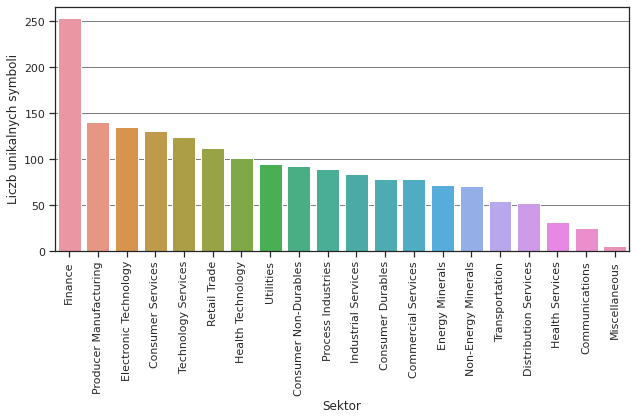

In [34]:
sns.set(rc={'figure.figsize':(9, 6)})
sns.set_style("ticks")
ax = sns.barplot(x="sector", y="symbol", data=df_groups)
ax.set(xlabel='Sektor', ylabel='Liczb unikalnych symboli')
for item in ax.get_xticklabels():
    item.set_rotation(90)
    
plt.grid(axis="y", color="black", linewidth=0.5)
plt.tight_layout()
plt.savefig('oryg_count.png')
plt.show()

### Pobranie danych Yahoo Finance za pomocą pakietu `yfinance` i Feature Enginnering

Przygotowanie listy symboli `company_list` do iteracji.


Zmienna dla daty początkowej `start_date` oraz końcowej `end_date` do pobrania danych. Przedział czasowy został rozszerzony w celu zniwelowania braków danych.

Stworzenie `data_df`, która będzie zawierała dane spółek zapisane wraz z symbolem spółki w tymczasowej dataframe `data`. Zapisanie `data_df` do pliku `yfinance_returns.csv` do ponownego użycia bez konieczności pobierania

Możliwe jest pobranie za pomocą pakietu całej listy jednocześnie, ale wtedy każda spółka zapisywana jest w osobnej kolumnie - zbiór z danymi będzie miały kilka tysięcy kolumn.

Dodanych zostanie kilka wybranych wskaźników finansowych, odpowiadających za volatilty, trend i momentum, pochodzące z pakietu Technical Analysis (https://towardsdatascience.com/technical-analysis-library-to-financial-datasets-with-pandas-python-4b2b390d3543)

Wyznaczone zostaną daty do wyznaczenia przyszłych stóp zwrotów dla miesiąca, kwartału, pół roku oraz roku od daty tickera i ceny `Adj Close` zapisane w `data_offset`, zgodnie z wymaganiami projektu. Dodanie cen `Adj Close` według dat `m_date`, `q_date`, `sa_date` i `y_date`. Dzięki `merge_asof`, w przypadku braku ceny z daty, zostanie wzięta inna kolejna (`direction="forward"`) wyznaczona cena, ponieważ ostatnie wartości "pochodzą z przyszłości", więc do przewidywania weźmiemy krótszy przedział czasowy. Po mergowaniu dane jednej spółki zapisywane są w `data_merged`, i łączone do `data_df` z wykorzystaniem funkcji `concat`. Po drodze zmieniane są nazwy kolumn oraz usuwane są zbędne kolumny powstałe podczas łączenia `data` oraz `data_offset` do `data_merged`. `mtd`, `qtd` nie oznaczają w sprawozdaniach i raportach finansowych tego co w naszym zbiorze (oznaczają stopę zwrotu od początku miesiąca, kwartału itd. do daty), ale dla przejrzystości przyjmujemy że `mtd`, `qtd` oznacza cenę `Adj Close` + miesiąc, + kwartał od daty w kolumnie `Date`.

`print` oraz `number` służyły informacyjnie - ile jeszcze spółek zostało do pobrania.

In [ ]:
company_list = list(df["symbol"].unique())
# company_list = ["SU", "GGU"]
start_date = "2003-12-31"
end_date = "2022-03-01"
data_df = pd.DataFrame()
number = 0
window_n = 14

for company in company_list:
    data = yf.download(company, start=start_date, end=end_date)
    print(company)
    data["symbol"] = company
    number += 1
    print(number)
    data = data.reset_index(level=0)
    if data.empty:
        continue
    data_offset = data[["Date", "symbol"]].copy()

    # Dodanie wksaźników finansowych pochodzących z pakietu ta
    data["dr"] = daily_return(data["Close"])
    data["cr"] = cumulative_return(data["Close"])

    indicator_bb = BollingerBands(data["Close"], window=20, window_dev=2)
    data["bb"] = indicator_bb.bollinger_mavg()

    indicator_dc = DonchianChannel(data["High"], data["Low"], data["Close"], window=window_n)
    data["dc"] = indicator_dc.donchian_channel_mband()

    indicator_cci = CCIIndicator(data["High"],data["Low"], data["Close"], window=window_n)
    data["cci"] = indicator_cci.cci()

    indicator_ema = EMAIndicator(data["High"], window=window_n)
    data["ema"] = indicator_ema.ema_indicator()
    
    indicator_kama = KAMAIndicator(data["Close"], window=window_n)
    data["kama"] = indicator_kama.kama()
    
    indicator_ppo = PercentagePriceOscillator(data["Close"])
    data["ppo"] = indicator_ppo.ppo()
    
    indicator_pvo = PercentageVolumeOscillator(data["Volume"])
    data["pvo"] = indicator_pvo.pvo()
    
    indicator_roc = ROCIndicator(data["Close"], window=window_n)
    data["roc"] = indicator_roc.roc()

    # kolumny służace do dodania daty w przyszłości
    data_offset["month"] = 1
    data_offset["quarter"] = 3
    data_offset["semi_annual"] = 6
    data_offset["year"] = 12 
    data_offset['m_date'] = data_offset['Date'] + data_offset['month'].astype('timedelta64[M]')
    data_offset['q_date'] = data_offset['Date'] + data_offset['quarter'].astype('timedelta64[M]')
    data_offset['sa_date'] = data_offset['Date'] + data_offset['semi_annual'].astype('timedelta64[M]')
    data_offset['y_date'] = data_offset['Date'] + data_offset['year'].astype('timedelta64[M]')
    date_cols_drop_list = ["month", "quarter", "semi_annual", "year"]
    data_offset.drop(date_cols_drop_list, axis=1, inplace=True)
    data_to_merge = data[["Date", "Adj Close"]].copy()

    # mtd
    data_merged = pd.merge(data_offset, data, left_on="Date", right_on="Date").drop("symbol_y", axis=1).rename(columns={"Adj Close": "Adj Close_date"})
    data_merged = pd.merge_asof(data_merged, data_to_merge, left_on="m_date", right_on="Date", direction="forward")
    data_merged = data_merged.rename(columns={"Adj Close": "Adj Close_mtd", "Date_x": "Date"}).drop("Date_y", axis=1)

    # qtd
    data_merged = pd.merge_asof(data_merged, data_to_merge, left_on="q_date", right_on="Date", direction="forward")
    data_merged = data_merged.rename(columns={"Adj Close": "Adj Close_qtd", "Date_x": "Date"}).drop("Date_y", axis=1)

    # htd
    data_merged = pd.merge_asof(data_merged, data_to_merge, left_on="sa_date", right_on="Date", direction="forward")
    data_merged = data_merged.rename(columns={"Adj Close": "Adj Close_htd", "Date_x": "Date"}).drop("Date_y", axis=1)

    # ytd
    data_merged = pd.merge_asof(data_merged, data_to_merge, left_on="y_date", right_on="Date", direction="forward")
    data_merged = data_merged.rename(columns={"Adj Close": "Adj Close_ytd", "Date_x": "Date", "symbol_x": "symbol"}).drop("Date_y", axis=1)


    # frames concat
    frames = [data_df, data_merged]
    data_df = pd.concat(frames)
    data_df.reset_index(drop=True, inplace=True)

data_df

In [ ]:
data_df.info(show_counts=True)

Zmiana nazw kolumn, usunięcie zbędnych kolumn, reorganizacja kolejności w celu łatwiejszego operowania danymi.

In [ ]:
data_df.rename(columns={"Date": "date", "Open": "open", "High": "high", "Low": "low", "Close": "close", "Adj Close_date": "adj_close_date", "Volume": "volume", "Adj Close_mtd": "adj_close_mtd", "Adj Close_qtd": "adj_close_qtd", "Adj Close_htd": "adj_close_htd", "Adj Close_ytd": "adj_close_ytd"}, inplace=True)
data_df.info(show_counts=True)

In [ ]:
data_df = data_df[['date', 'symbol', 'open', 'high', 'close', 'low', 'volume', 'dr', 'cr', 'bb', 'dc', 'cci', 'ema', 'kama', 'ppo', 'pvo', 'roc', 'adj_close_date', 'adj_close_mtd', 'adj_close_qtd', 'adj_close_htd', 'adj_close_ytd']]
data_df.info(show_counts=True)

Zapisanie `data_df` do `yfinance_returns.csv`

In [ ]:
data_df.to_csv("/content/drive/MyDrive/Colab Notebooks/UMF/yfinance_returns.csv")

Wczytanie zbioru `yfinance_returns.csv`.

In [73]:
data_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/UMF/yfinance_returns.csv", index_col=0)
data_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5637166 entries, 0 to 5637165
Data columns (total 22 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   date            5637166 non-null  object 
 1   symbol          5637166 non-null  object 
 2   open            5637094 non-null  float64
 3   high            5637094 non-null  float64
 4   close           5637094 non-null  float64
 5   low             5637094 non-null  float64
 6   volume          5637094 non-null  float64
 7   dr              5637043 non-null  float64
 8   cr              5530372 non-null  float64
 9   bb              5609256 non-null  float64
 10  dc              5618040 non-null  float64
 11  cci             5552646 non-null  float64
 12  ema             5618405 non-null  float64
 13  kama            5245605 non-null  float64
 14  ppo             5601149 non-null  float64
 15  pvo             5600204 non-null  float64
 16  roc             5616914 non-null  fl

In [74]:
data_df

,date,symbol,open,high,close,low,volume,dr,cr,bb,...,ema,kama,ppo,pvo,roc,adj_close_date,adj_close_mtd,adj_close_qtd,adj_close_htd,adj_close_ytd
0,2003-12-31,SU,12.555000,12.710000,12.530000,12.500000,1581000.0,-59.897594,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,8.724124,8.912115,9.740978,8.821676,12.394953
1,2004-01-02,SU,12.505000,12.765000,12.735000,12.505000,981200.0,1.636073,1.636073,NaN,...,NaN,NaN,NaN,NaN,NaN,8.866860,8.912115,9.671227,9.153583,11.879365
2,2004-01-05,SU,12.925000,12.925000,12.850000,12.775000,1450800.0,0.903029,2.553876,NaN,...,NaN,NaN,NaN,NaN,NaN,8.946930,8.779828,9.207373,9.094193,11.500576
3,2004-01-06,SU,13.000000,13.110000,13.095000,12.840000,1173600.0,1.906614,4.509182,NaN,...,NaN,NaN,NaN,NaN,NaN,9.117510,8.790277,9.207373,9.094193,11.290134
4,2004-01-07,SU,13.100000,13.100000,12.865000,12.775000,785400.0,-1.756399,2.673584,NaN,...,NaN,NaN,NaN,NaN,NaN,8.957374,8.849455,8.994630,9.094193,11.398862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5637161,2022-02-22,AGCO,127.550003,128.820007,122.339996,121.930000,660800.0,-4.429340,507.447865,122.338999,...,128.428469,125.218009,1.970952,3.480049,3.520051,117.659843,NaN,NaN,NaN,NaN
5637162,2022-02-23,AGCO,123.169998,123.169998,117.279999,116.849998,548000.0,-4.136013,482.323745,122.371999,...,127.727339,125.169184,1.266027,0.703830,0.842645,112.793419,NaN,NaN,NaN,NaN
5637163,2022-02-24,AGCO,113.820000,118.550003,118.160004,112.559998,911800.0,0.750345,486.693184,122.461499,...,126.503694,125.095102,0.752721,2.304680,2.338476,113.639755,NaN,NaN,NaN,NaN
5637164,2022-02-25,AGCO,118.279999,120.029999,118.389999,116.930000,756500.0,0.194648,487.835169,122.713499,...,125.640535,124.997759,0.354897,1.912388,3.388348,113.860954,NaN,NaN,NaN,NaN


Zapisanie kolumny `date` jako obiekt `datetime` w przypadku wczytywania zbioru `yfinance_returns.csv`.

In [76]:
data_df["date"] = pd.to_datetime(data_df["date"], format="%Y-%m-%d")
data_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5637166 entries, 0 to 5637165
Data columns (total 22 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   date            5637166 non-null  datetime64[ns]
 1   symbol          5637166 non-null  object        
 2   open            5637094 non-null  float64       
 3   high            5637094 non-null  float64       
 4   close           5637094 non-null  float64       
 5   low             5637094 non-null  float64       
 6   volume          5637094 non-null  float64       
 7   dr              5637043 non-null  float64       
 8   cr              5530372 non-null  float64       
 9   bb              5609256 non-null  float64       
 10  dc              5618040 non-null  float64       
 11  cci             5552646 non-null  float64       
 12  ema             5618405 non-null  float64       
 13  kama            5245605 non-null  float64       
 14  ppo             56

Dodanie kolumny `year`, `month`, `day`, `week_day` będące pochodnymi kolumny `Date`. Poszczególne lata otrzymają liczbę porządkową.

In [77]:
data_df["year"] = data_df['date'].dt.year
data_df["month"] = data_df['date'].dt.month
data_df["day"] = data_df['date'].dt.day
data_df['weekday'] = data_df['date'].dt.weekday
data_df['year'] = data_df["year"] - 2003
data_df

,date,symbol,open,high,close,low,volume,dr,cr,bb,...,roc,adj_close_date,adj_close_mtd,adj_close_qtd,adj_close_htd,adj_close_ytd,year,month,day,weekday
0,2003-12-31,SU,12.555000,12.710000,12.530000,12.500000,1581000.0,-59.897594,0.000000,NaN,...,NaN,8.724124,8.912115,9.740978,8.821676,12.394953,0,12,31,2
1,2004-01-02,SU,12.505000,12.765000,12.735000,12.505000,981200.0,1.636073,1.636073,NaN,...,NaN,8.866860,8.912115,9.671227,9.153583,11.879365,1,1,2,4
2,2004-01-05,SU,12.925000,12.925000,12.850000,12.775000,1450800.0,0.903029,2.553876,NaN,...,NaN,8.946930,8.779828,9.207373,9.094193,11.500576,1,1,5,0
3,2004-01-06,SU,13.000000,13.110000,13.095000,12.840000,1173600.0,1.906614,4.509182,NaN,...,NaN,9.117510,8.790277,9.207373,9.094193,11.290134,1,1,6,1
4,2004-01-07,SU,13.100000,13.100000,12.865000,12.775000,785400.0,-1.756399,2.673584,NaN,...,NaN,8.957374,8.849455,8.994630,9.094193,11.398862,1,1,7,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5637161,2022-02-22,AGCO,127.550003,128.820007,122.339996,121.930000,660800.0,-4.429340,507.447865,122.338999,...,3.520051,117.659843,NaN,NaN,NaN,NaN,19,2,22,1
5637162,2022-02-23,AGCO,123.169998,123.169998,117.279999,116.849998,548000.0,-4.136013,482.323745,122.371999,...,0.842645,112.793419,NaN,NaN,NaN,NaN,19,2,23,2
5637163,2022-02-24,AGCO,113.820000,118.550003,118.160004,112.559998,911800.0,0.750345,486.693184,122.461499,...,2.338476,113.639755,NaN,NaN,NaN,NaN,19,2,24,3
5637164,2022-02-25,AGCO,118.279999,120.029999,118.389999,116.930000,756500.0,0.194648,487.835169,122.713499,...,3.388348,113.860954,NaN,NaN,NaN,NaN,19,2,25,4


In [78]:
data_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5637166 entries, 0 to 5637165
Data columns (total 26 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   date            5637166 non-null  datetime64[ns]
 1   symbol          5637166 non-null  object        
 2   open            5637094 non-null  float64       
 3   high            5637094 non-null  float64       
 4   close           5637094 non-null  float64       
 5   low             5637094 non-null  float64       
 6   volume          5637094 non-null  float64       
 7   dr              5637043 non-null  float64       
 8   cr              5530372 non-null  float64       
 9   bb              5609256 non-null  float64       
 10  dc              5618040 non-null  float64       
 11  cci             5552646 non-null  float64       
 12  ema             5618405 non-null  float64       
 13  kama            5245605 non-null  float64       
 14  ppo             56

Połączenie zbiorów `df` i `data_df` i zapisanie do osobnego pliku.

In [79]:
final_df = pd.merge(df, data_df, how="left", left_on=["date", "symbol"], right_on=["date", "symbol"])
final_df

,date,symbol,sector,conviction,open,high,close,low,volume,dr,...,roc,adj_close_date,adj_close_mtd,adj_close_qtd,adj_close_htd,adj_close_ytd,year,month,day,weekday
0,2004-02-11,SU,Energy Minerals,0.953727,13.300000,13.365000,13.285000,13.130000,1280800.0,0.834912,...,0.113032,9.249799,9.475924,8.478457,9.726552,12.538750,1.0,2.0,11.0,2.0
1,2004-02-11,GGG,Producer Manufacturing,0.952753,9.282222,9.406667,9.388889,9.244444,518400.0,1.173379,...,6.557378,6.536161,6.573896,6.845714,7.591326,9.304582,1.0,2.0,11.0,2.0
2,2004-02-11,WGR,Energy Minerals,0.947634,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2004-02-11,CWT,Utilities,0.934181,14.650000,14.720000,14.720000,14.550000,45800.0,0.477820,...,1.868515,9.002892,8.874455,8.466928,8.612760,10.808844,1.0,2.0,11.0,2.0
4,2004-02-11,BLL,Process Industries,0.922862,8.047500,8.127500,8.095000,8.007500,3648800.0,-0.491702,...,10.117328,6.898208,7.013620,6.748834,7.818182,9.416622,1.0,2.0,11.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37355,2022-02-09,PEP,Consumer Non-Durables,0.701507,172.500000,172.779999,171.940002,171.009995,6780200.0,-0.046507,...,-1.149822,171.940002,NaN,NaN,NaN,NaN,19.0,2.0,9.0,2.0
37356,2022-02-09,SSNC,Technology Services,0.701123,81.419998,82.459999,82.419998,81.209999,966800.0,2.093391,...,1.640155,82.201866,NaN,NaN,NaN,NaN,19.0,2.0,9.0,2.0
37357,2022-02-09,GEF,Process Industries,0.697954,58.410000,58.880001,56.930000,56.700001,292600.0,-1.641328,...,-6.916284,56.489128,NaN,NaN,NaN,NaN,19.0,2.0,9.0,2.0
37358,2022-02-09,DPZ,Consumer Services,0.697741,443.970001,449.450012,444.760010,439.559998,372000.0,1.374421,...,-1.660508,443.493774,NaN,NaN,NaN,NaN,19.0,2.0,9.0,2.0


In [80]:
final_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37360 entries, 0 to 37359
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            37360 non-null  datetime64[ns]
 1   symbol          37360 non-null  object        
 2   sector          37360 non-null  object        
 3   conviction      37360 non-null  float64       
 4   open            30517 non-null  float64       
 5   high            30517 non-null  float64       
 6   close           30517 non-null  float64       
 7   low             30517 non-null  float64       
 8   volume          30517 non-null  float64       
 9   dr              30517 non-null  float64       
 10  cr              29833 non-null  float64       
 11  bb              30509 non-null  float64       
 12  dc              30513 non-null  float64       
 13  cci             30341 non-null  float64       
 14  ema             30515 non-null  float64       
 15  ka

In [81]:
final_df = final_df[['year', 'month', 'day','weekday','symbol', 'sector', 'conviction', 'open', 'high', 'close', 'low', 'volume', 'dr', 'cr', 'bb', 'dc', 'cci', 'ema', 'kama', 'ppo', 'pvo', 'roc', 'adj_close_date', 'adj_close_mtd', 'adj_close_qtd', 'adj_close_htd', 'adj_close_ytd']]
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37360 entries, 0 to 37359
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            30517 non-null  float64
 1   month           30517 non-null  float64
 2   day             30517 non-null  float64
 3   weekday         30517 non-null  float64
 4   symbol          37360 non-null  object 
 5   sector          37360 non-null  object 
 6   conviction      37360 non-null  float64
 7   open            30517 non-null  float64
 8   high            30517 non-null  float64
 9   close           30517 non-null  float64
 10  low             30517 non-null  float64
 11  volume          30517 non-null  float64
 12  dr              30517 non-null  float64
 13  cr              29833 non-null  float64
 14  bb              30509 non-null  float64
 15  dc              30513 non-null  float64
 16  cci             30341 non-null  float64
 17  ema             30515 non-null 

In [82]:
final_df

,year,month,day,weekday,symbol,sector,conviction,open,high,close,...,ema,kama,ppo,pvo,roc,adj_close_date,adj_close_mtd,adj_close_qtd,adj_close_htd,adj_close_ytd
0,1.0,2.0,11.0,2.0,SU,Energy Minerals,0.953727,13.300000,13.365000,13.285000,...,13.074966,13.294546,0.351834,-1.130415,0.113032,9.249799,9.475924,8.478457,9.726552,12.538750
1,1.0,2.0,11.0,2.0,GGG,Producer Manufacturing,0.952753,9.282222,9.406667,9.388889,...,9.184128,9.052690,0.866377,5.573530,6.557378,6.536161,6.573896,6.845714,7.591326,9.304582
2,NaN,NaN,NaN,NaN,WGR,Energy Minerals,0.947634,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,2.0,11.0,2.0,CWT,Utilities,0.934181,14.650000,14.720000,14.720000,...,14.445180,14.432016,0.562174,-1.852853,1.868515,9.002892,8.874455,8.466928,8.612760,10.808844
4,1.0,2.0,11.0,2.0,BLL,Process Industries,0.922862,8.047500,8.127500,8.095000,...,7.908240,7.969739,2.576472,9.683535,10.117328,6.898208,7.013620,6.748834,7.818182,9.416622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37355,19.0,2.0,9.0,2.0,PEP,Consumer Non-Durables,0.701507,172.500000,172.779999,171.940002,...,173.972302,172.577284,0.161353,0.667692,-1.149822,171.940002,NaN,NaN,NaN,NaN
37356,19.0,2.0,9.0,2.0,SSNC,Technology Services,0.701123,81.419998,82.459999,82.419998,...,80.997328,79.730989,-0.011642,-4.550312,1.640155,82.201866,NaN,NaN,NaN,NaN
37357,19.0,2.0,9.0,2.0,GEF,Process Industries,0.697954,58.410000,58.880001,56.930000,...,59.563719,59.586639,-1.585367,0.169304,-6.916284,56.489128,NaN,NaN,NaN,NaN
37358,19.0,2.0,9.0,2.0,DPZ,Consumer Services,0.697741,443.970001,449.450012,444.760010,...,456.010892,445.691430,-3.758596,-8.236462,-1.660508,443.493774,NaN,NaN,NaN,NaN


In [84]:
final_df.dropna(axis=0, inplace=True, how="any")
final_df.reset_index(inplace=True, drop=True)
final_df

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,year,month,day,weekday,symbol,sector,conviction,open,high,close,...,ema,kama,ppo,pvo,roc,adj_close_date,adj_close_mtd,adj_close_qtd,adj_close_htd,adj_close_ytd
0,1.0,2.0,11.0,2.0,SU,Energy Minerals,0.953727,13.300000,13.365000,13.285000,...,13.074966,13.294546,0.351834,-1.130415,0.113032,9.249799,9.475924,8.478457,9.726552,12.538750
1,1.0,2.0,11.0,2.0,GGG,Producer Manufacturing,0.952753,9.282222,9.406667,9.388889,...,9.184128,9.052690,0.866377,5.573530,6.557378,6.536161,6.573896,6.845714,7.591326,9.304582
2,1.0,2.0,11.0,2.0,CWT,Utilities,0.934181,14.650000,14.720000,14.720000,...,14.445180,14.432016,0.562174,-1.852853,1.868515,9.002892,8.874455,8.466928,8.612760,10.808844
3,1.0,2.0,11.0,2.0,BLL,Process Industries,0.922862,8.047500,8.127500,8.095000,...,7.908240,7.969739,2.576472,9.683535,10.117328,6.898208,7.013620,6.748834,7.818182,9.416622
4,1.0,2.0,11.0,2.0,APA,Energy Minerals,0.912117,39.549999,39.980000,39.830002,...,39.802467,39.843193,-1.645296,4.436061,-5.211801,31.821821,33.755253,32.688286,35.229458,45.768177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26591,18.0,2.0,24.0,2.0,UVV,Consumer Non-Durables,0.603751,51.299999,51.810001,51.740002,...,51.294121,49.620815,1.299493,-4.908623,11.149307,48.267147,54.853264,55.815964,47.006256,51.859703
26592,18.0,2.0,24.0,2.0,NPK,Consumer Durables,0.603630,109.500000,117.870003,117.870003,...,102.311681,100.297184,4.034012,34.321970,22.870846,107.692818,96.661072,96.785622,83.832336,76.982033
26593,18.0,2.0,24.0,2.0,AEM,Non-Energy Minerals,0.596055,59.779999,61.950001,61.639999,...,65.856714,66.367698,-3.875571,7.778740,-11.040556,59.726414,57.530659,70.475548,57.087807,51.605988
26594,18.0,2.0,24.0,2.0,GNTX,Producer Manufacturing,0.593573,35.849998,36.240002,36.060001,...,35.787381,35.247010,0.775285,-3.827232,4.069263,35.807487,35.122314,34.622944,31.430000,30.090000


In [85]:
final_df["symbol"].nunique()

1192

In [86]:
final_df_groups = final_df.groupby("sector")["symbol"].nunique().reset_index().copy()
final_df_groups = final_df_groups.sort_values('symbol', ascending=False)

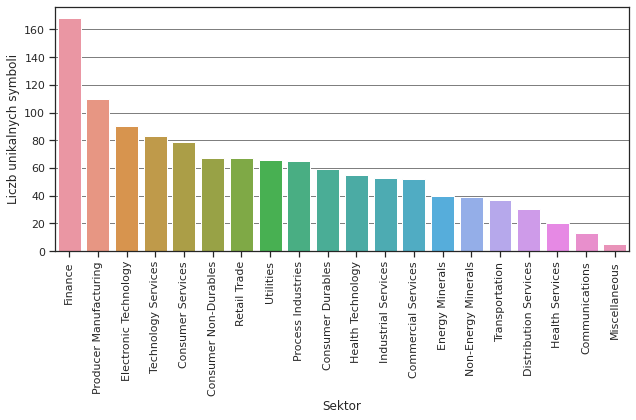

In [87]:
sns.set(rc={'figure.figsize':(9, 6)})
sns.set_style("ticks")
ax = sns.barplot(x="sector", y="symbol", data=final_df_groups)
ax.set(xlabel='Sektor', ylabel='Liczb unikalnych symboli')
for item in ax.get_xticklabels():
    item.set_rotation(90)
    
plt.grid(axis="y", color="black", linewidth=0.5)
plt.tight_layout()
plt.savefig('oryg_count_final.png')
plt.show()

In [88]:
final_df.loc[:,'symbol'] = LabelEncoder().fit_transform(final_df.loc[:,'symbol'].copy())
final_df.loc[:,'sector'] = LabelEncoder().fit_transform(final_df.loc[:,'sector'].copy())
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26596 entries, 0 to 26595
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            26596 non-null  float64
 1   month           26596 non-null  float64
 2   day             26596 non-null  float64
 3   weekday         26596 non-null  float64
 4   symbol          26596 non-null  int64  
 5   sector          26596 non-null  int64  
 6   conviction      26596 non-null  float64
 7   open            26596 non-null  float64
 8   high            26596 non-null  float64
 9   close           26596 non-null  float64
 10  low             26596 non-null  float64
 11  volume          26596 non-null  float64
 12  dr              26596 non-null  float64
 13  cr              26596 non-null  float64
 14  bb              26596 non-null  float64
 15  dc              26596 non-null  float64
 16  cci             26596 non-null  float64
 17  ema             26596 non-null 

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [89]:
final_df[["year", "month", "day", "weekday"]] = final_df[["year", "month", "day", "weekday"]].astype('int')
final_df.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,year,month,day,weekday,symbol,sector,conviction,open,high,close,...,ema,kama,ppo,pvo,roc,adj_close_date,adj_close_mtd,adj_close_qtd,adj_close_htd,adj_close_ytd
0,1,2,11,2,1009,7,0.953727,13.300000,13.365000,13.285000,...,13.074966,13.294546,0.351834,-1.130415,0.113032,9.249799,9.475924,8.478457,9.726552,12.538750
1,1,2,11,2,456,15,0.952753,9.282222,9.406667,9.388889,...,9.184128,9.052690,0.866377,5.573530,6.557378,6.536161,6.573896,6.845714,7.591326,9.304582
2,1,2,11,2,281,19,0.934181,14.650000,14.720000,14.720000,...,14.445180,14.432016,0.562174,-1.852853,1.868515,9.002892,8.874455,8.466928,8.612760,10.808844
3,1,2,11,2,138,14,0.922862,8.047500,8.127500,8.095000,...,7.908240,7.969739,2.576472,9.683535,10.117328,6.898208,7.013620,6.748834,7.818182,9.416622
4,1,2,11,2,64,7,0.912117,39.549999,39.980000,39.830002,...,39.802467,39.843193,-1.645296,4.436061,-5.211801,31.821821,33.755253,32.688286,35.229458,45.768177


In [90]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26596 entries, 0 to 26595
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            26596 non-null  int64  
 1   month           26596 non-null  int64  
 2   day             26596 non-null  int64  
 3   weekday         26596 non-null  int64  
 4   symbol          26596 non-null  int64  
 5   sector          26596 non-null  int64  
 6   conviction      26596 non-null  float64
 7   open            26596 non-null  float64
 8   high            26596 non-null  float64
 9   close           26596 non-null  float64
 10  low             26596 non-null  float64
 11  volume          26596 non-null  float64
 12  dr              26596 non-null  float64
 13  cr              26596 non-null  float64
 14  bb              26596 non-null  float64
 15  dc              26596 non-null  float64
 16  cci             26596 non-null  float64
 17  ema             26596 non-null 

In [91]:
final_df.to_csv("/content/drive/MyDrive/Colab Notebooks/UMF/convictions_returns.csv")

### Initial modelling


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
final_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/UMF/convictions_returns.csv", index_col=0)
final_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37334 entries, 0 to 37333
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            37334 non-null  object 
 1   symbol          37334 non-null  object 
 2   sector          37334 non-null  object 
 3   conviction      37334 non-null  float64
 4   open            30517 non-null  float64
 5   high            30517 non-null  float64
 6   close           30517 non-null  float64
 7   low             30517 non-null  float64
 8   volume          30517 non-null  float64
 9   dr              30517 non-null  float64
 10  cr              29833 non-null  float64
 11  bb              30509 non-null  float64
 12  dc              30513 non-null  float64
 13  cci             30341 non-null  float64
 14  ema             30515 non-null  float64
 15  kama            29194 non-null  float64
 16  ppo             30511 non-null  float64
 17  pvo             30504 non-null 

Zamienienie columny `adj_close_mtd` na ror w odniesieniu do ceny z daty

In [ ]:
final_df["adj_close_mtd"] = (final_df["adj_close_mtd"] - final_df["adj_close_date"])/final_df["adj_close_date"]
# final_df = final_df.round(decimals=2)
final_df.head()

,year,month,day,weekday,symbol,sector,open,high,close,low,...,ema,kama,ppo,pvo,roc,adj_close_date,adj_close_mtd,adj_close_qtd,adj_close_htd,adj_close_ytd
0,1,2,11,2,1544,7,13.300000,13.365000,13.285000,13.130000,...,13.074966,13.294546,0.351834,-1.130415,0.113032,9.249799,0.024446,8.478457,9.726552,12.538750
1,1,2,11,2,696,15,9.282222,9.406667,9.388889,9.244444,...,9.184128,9.052690,0.866377,5.573530,6.557378,6.536161,0.005773,6.845714,7.591326,9.304582
3,1,2,11,2,449,19,14.650000,14.720000,14.720000,14.550000,...,14.445180,14.432016,0.562174,-1.852853,1.868515,9.002892,-0.014266,8.466928,8.612760,10.808844
4,1,2,11,2,220,14,8.047500,8.127500,8.095000,8.007500,...,7.908240,7.969739,2.576472,9.683535,10.117328,6.898208,0.016731,6.748834,7.818182,9.416622
5,1,2,11,2,101,7,39.549999,39.980000,39.830002,39.119999,...,39.802467,39.843193,-1.645296,4.436061,-5.211801,31.821821,0.060758,32.688286,35.229458,45.768177


In [ ]:
features = final_df.iloc[:, :22]
target = final_df.iloc[:, 22:]


X_train, X_test, Y_train, Y_test = train_test_split(features, 
                                                    target, 
                                                    test_size = 0.3, 
                                                    random_state = 20)
Y_train.head()

,adj_close_mtd,adj_close_qtd,adj_close_htd,adj_close_ytd
33363,-0.003184,46.926060,42.190475,67.263832
18551,0.113782,37.905422,32.015762,36.538235
31770,0.084088,32.733002,37.091000,14.446000
28297,0.044726,86.665108,76.004768,51.826851
28275,0.019679,47.186493,43.327839,49.669636


In [ ]:
%%timeit -n 1 -r 1
lr_reg = LinearRegression()
lr_reg.fit(X_train, Y_train["adj_close_mtd"])
Y_pred_lr_reg = lr_reg.predict(X_test)

print(r2_score(Y_test["adj_close_mtd"], Y_pred_lr_reg))

-8.643773301564295e-05
1 loop, best of 1: 27.8 ms per loop


XGBoost


In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error as MSE
param = {"booster":"gblinear", "objective":"reg:squarederror"}

train_dmatrix = xgb.DMatrix(data=X_train, label=Y_train["adj_close_mtd"])
test_dmatrix = xgb.DMatrix(data=X_test, label=Y_test["adj_close_mtd"])
xgb_r = xgb.train(params=param, dtrain=train_dmatrix, num_boost_round = 10)
xgb_pred = xgb_r.predict(test_dmatrix)

rmse = np.sqrt(MSE(Y_test["adj_close_mtd"], xgb_pred))
print("RMSE : % f" %(rmse))
print(r2_score(Y_test["adj_close_mtd"], xgb_pred))

RMSE :  0.109178
-0.11502609866483526
